# Diamond Price Prediction
***
## Table of Contents 
1. [Introduction](#1-introduction)
1. [Loading Data](#2-loading-data)
1. [Exploratory Data Analysis](#3-exploratory-data-analysis)
1. [Data Preprocessing](#4-data-preprocessing)
    - [Log Transformation](#log-transformation)
    - [Dealing with Outliers](#dealing-with-outliers)
    - [Handling Categorical Features](#handling-categorical-features)
    - [Standardisation](#standardisation)
1. [Perdictive Modelling](#5-predictive-modelling)
    - [Hyperparameter Tuning](#hyperparameter-tuning)
    - [Evaluation on Test Data](#evaluation-on-test-data)
1. [Conclusion](#6-conclusion)
1. [References](#7-references)
***


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype
from typing import Dict, Any

## 1. Introduction
Diamond is 58 times harder than any other mineral in the world, and its elegance as a gemstone has long been admired. The diamond industry relies heavily on accurate and objective valuation, as prices are determined by a combination of physical and qualitative attributes. By applying machine learning algorithms, we can estimate diamond prices more effectively, thereby supporting jewellers, investors, and consumers in making informed decisions.

The objective of this project is to develop and compare multiple predictive models to accurately estimate the price of diamonds based on their features, providing actionable insights for stakeholders, jewellers, and clients in the diamond industry.

## 2. Loading Data
Retrieved from [Kaggle - Diamonds](https://www.kaggle.com/datasets/shivam2503/diamonds)
- **price**: Price in US dollars ($326 - $18,823). Target variable.
- **carat**: Weight of the diamond (0.2 - 5.01)
- **cut**: Quality of the cut (Fair, Good, Very Good, Premium, Ideal)
- **color**: Diamond colour, from J (worst) to D (best)
- **clarity**: Measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
- **x**: Length in mm (0 - 10.74)
- **y**: Width in mm (0 - 58.9)
- **z**: Depth in mm (0 - 31.8)
- **depth**: Total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43-79)
- **table**: Width of top of diamond relative to widest point (43-95)

In [2]:
df = pd.read_csv("_datasets/diamonds.csv")
df = df.drop("Unnamed: 0", axis=1)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [3]:
df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [4]:
df.shape

(53940, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


## 3. Exploratory Data Analysis

In [6]:
def plot_correlation_matrix(
    df: pd.DataFrame, method: str = "pearson", annot: bool = True
) -> None:
    """
    Plot a correlation matrix heatmap for all numerical columns in a DataFrame.

    Args:
        df: The input DataFrame containing the dataset.
        method: The correlation method to use. Supported values are
            'pearson', 'kendall', and 'spearman'. Defaults to 'pearson'.
        annot: Whether to display the correlation coefficients as annotations
            on the heatmap. Defaults to True.
    """
    num_columns = df.select_dtypes(include="number")
    plt.figure(figsize=(12, 8))
    corr = num_columns.corr(method=method)
    sns.heatmap(corr, annot=annot, fmt=".2f", cmap="coolwarm", square=True)
    plt.title(f"{method.title()} Correlation Matrix", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.yticks()
    plt.tight_layout()
    plt.show()

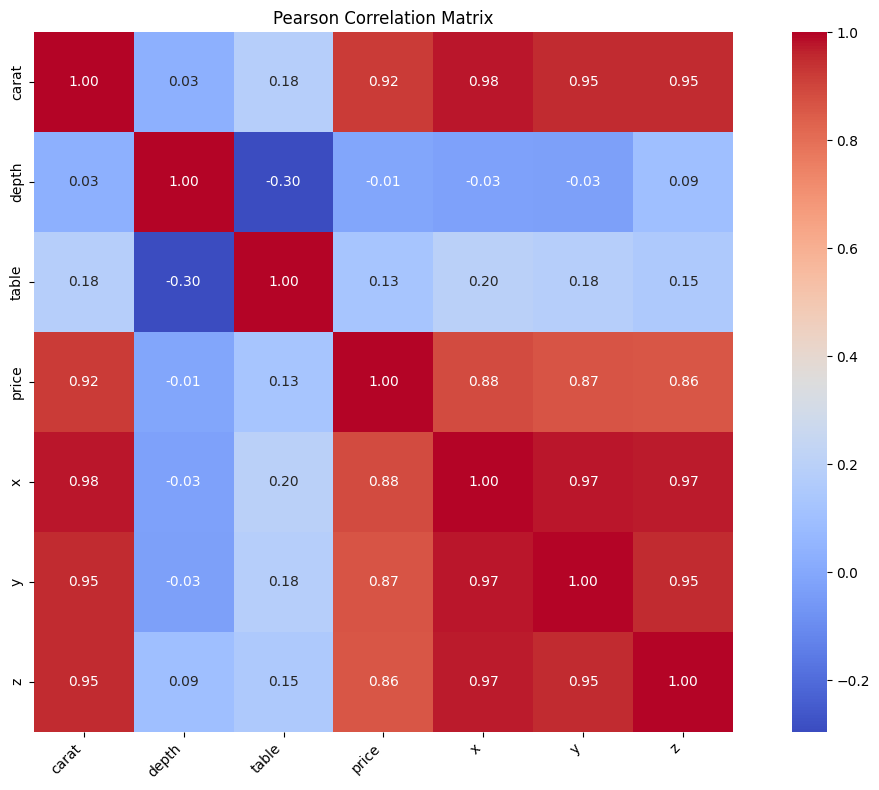

In [7]:
plot_correlation_matrix(df)

The Pearson correlation matrix indicates that the target variable (**price**) has strong correlations with carat ($0.95$), length ($0.88$), width ($0.87$) and depth ($0.86$).

In [8]:
def plot_distributions(df: pd.DataFrame) -> None:
    """
    Visualise the distributions of all columns in a DataFrame using histograms for numeric features
    and count plots for categorical features.

    Args:
        df: The input DataFrame containing the features to be visualised.
    """
    n_cols = df.shape[1]
    fig, axes = plt.subplots(3, 4, figsize=(20, 12))
    axes = axes.flatten()

    for i, col in enumerate(df.columns):
        ax = axes[i]
        if is_numeric_dtype(df[col]):
            sns.histplot(df[col], kde=True, ax=ax, edgecolor="black")
            ax.set_title(f"Distribution of {col}")
        else:
            sns.countplot(
                data=df,
                x=col,
                ax=ax,
                hue=col,
                palette="Set2",
                edgecolor="black",
                order=df[col].value_counts(ascending=True).index,
            )
            ax.set_title(f"Count of {col}")

    if n_cols < len(axes):
        for j in range(n_cols, len(axes)):
            fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

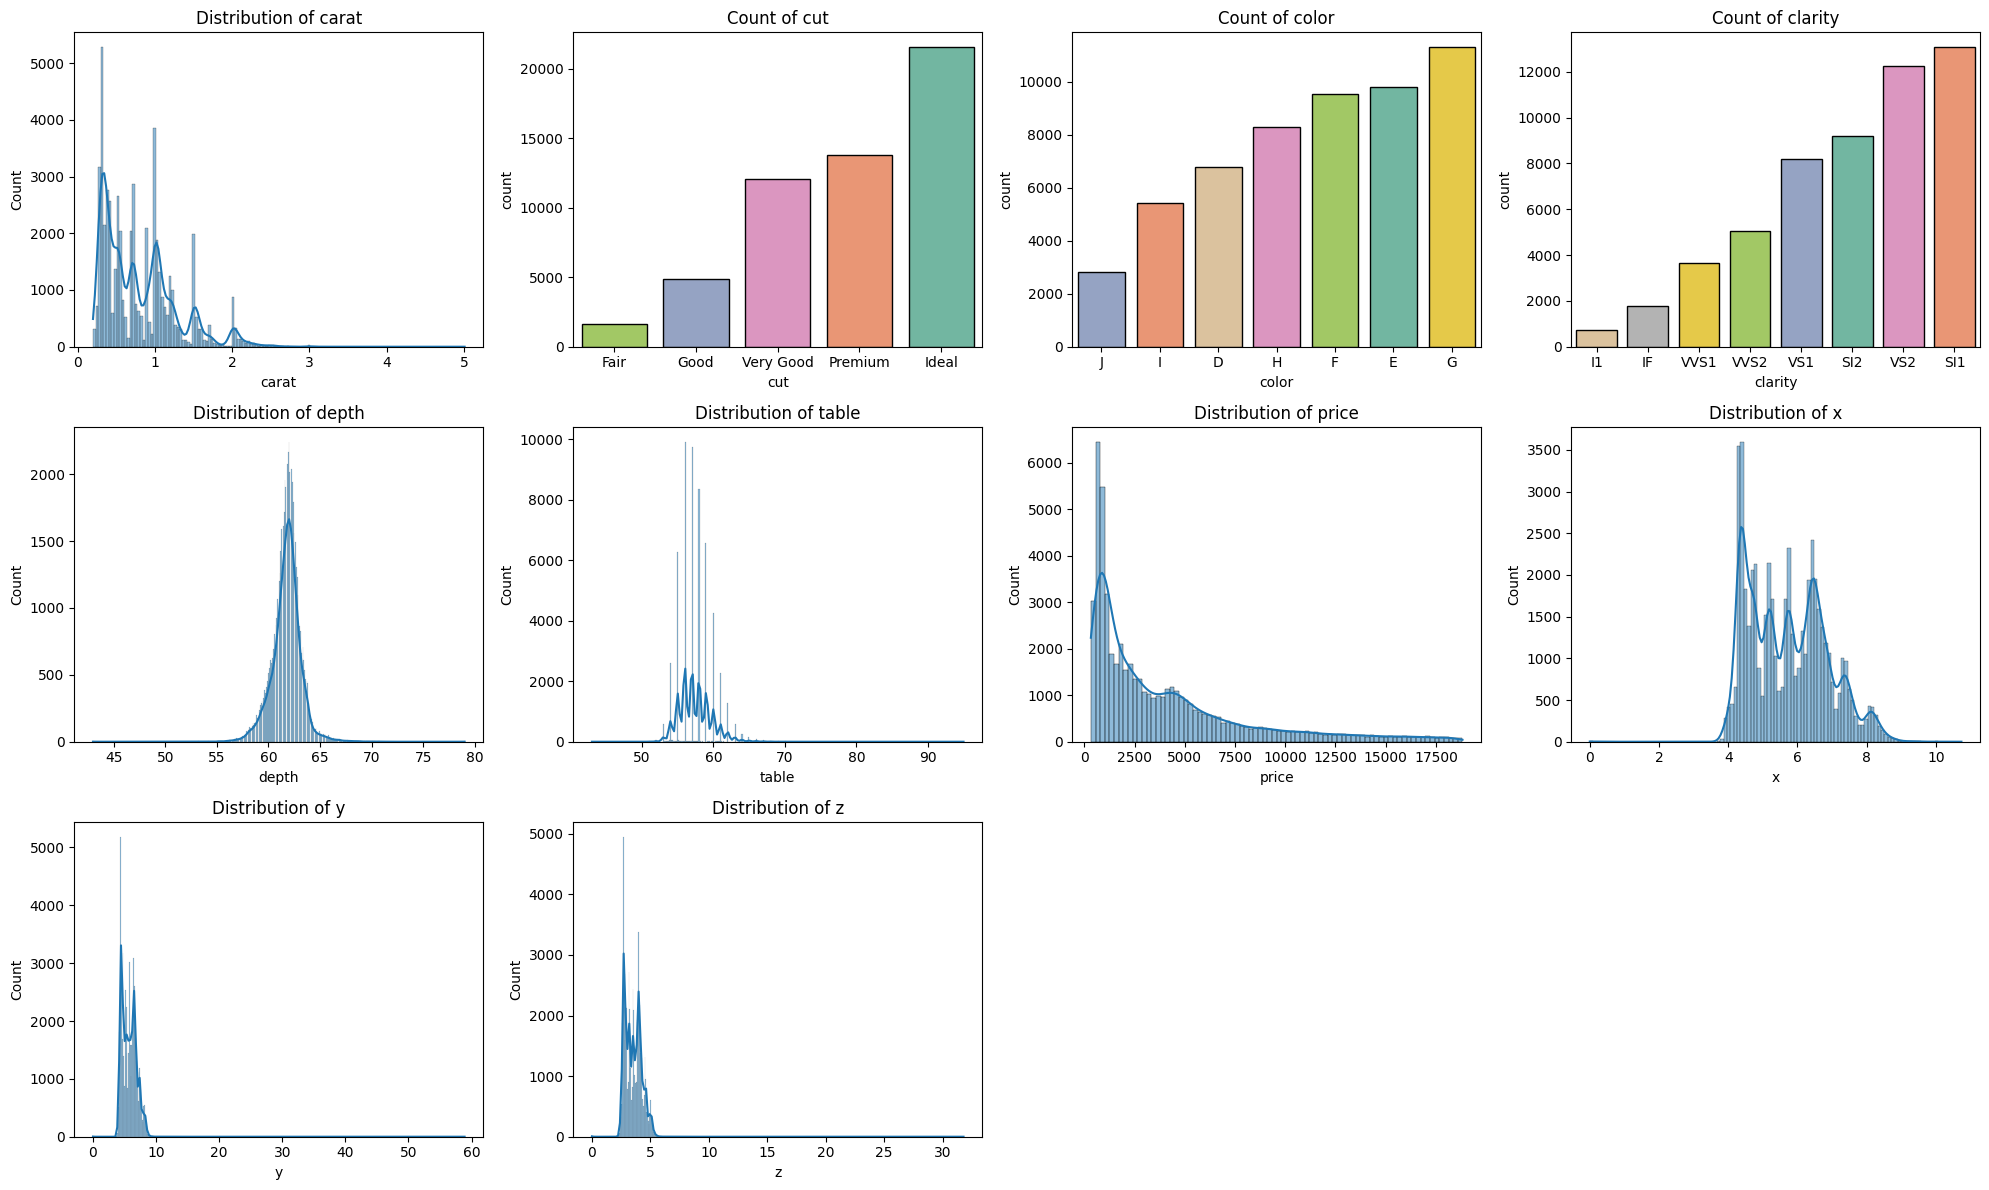

In [9]:
plot_distributions(df)

Analysing the feature distributions, several key insights have been revealed:
- The **carat** distribution is right-skewed, meaning that the most diamonds have a low carat weight. Some diamonds are significantly heavier, but they are rare.
- The `Ideal` **cut** is the most common, followed by `Premium` and `Very Good`. This indicates a preference for higher quality cuts in the dataset.
- Diamonds with **colour** grades `G`, `E`, `H` and `F` are more prevalent, while `J` and `D` are less common. Thus most diamonds fall into the middle colour range.
- Most diamonds fall into the middle **clarity** range, with extremes (`I1` and `IF`) being rare.
- Both **depth** and **table** are approximately normally distributed.
- The **price** distribution is highly right-skewed. Most diamonds are priced at the lower end, with a long tail extending to very high prices. This skewness is typical in luxury goods, where a few exceptional items command premium prices. 
- The length (**x**), width (**y**) and depth (**z**) are also right-skewed, with most values clustered at lower ranges.

## 4. Data Preprocessing
### Log Transformation
The target variable `price` is highly right-skewed with a long tail of high values. Applying a logarithmic transformation reduces skewness, making the distribution more symmetric and closer to normal.

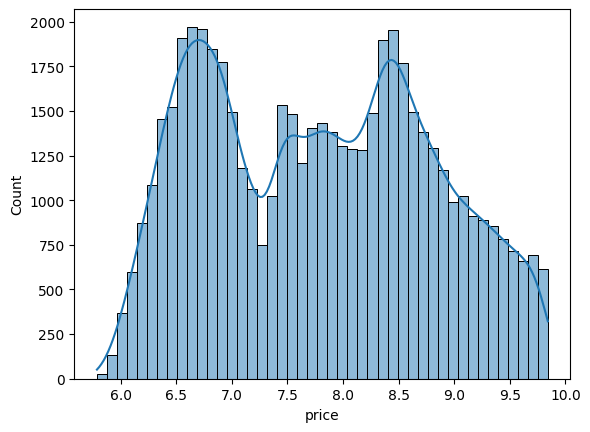

In [10]:
df["price"] = np.log(df["price"])

sns.histplot(df["price"], kde=True, edgecolor="black")
plt.show()

### Dealing with Outliers

In [11]:
def plot_boxplots(df: pd.DataFrame) -> None:
    """
    Generate boxplots for each numerical column in the dataset to visualise outliers.

    Args:
        df: The input dataframe.
    """
    numerical_columns = df.select_dtypes(include="number").columns

    fix, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 12))
    axes = axes.flatten()

    for i, column in enumerate(numerical_columns):
        sns.boxplot(data=df, y=column, ax=axes[i], color="skyblue")
        axes[i].set_title(f"Box plot for {column}")
        axes[i].set_ylabel(column)
        axes[i].set_xlabel("")

    # Remove unused subplots if any
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

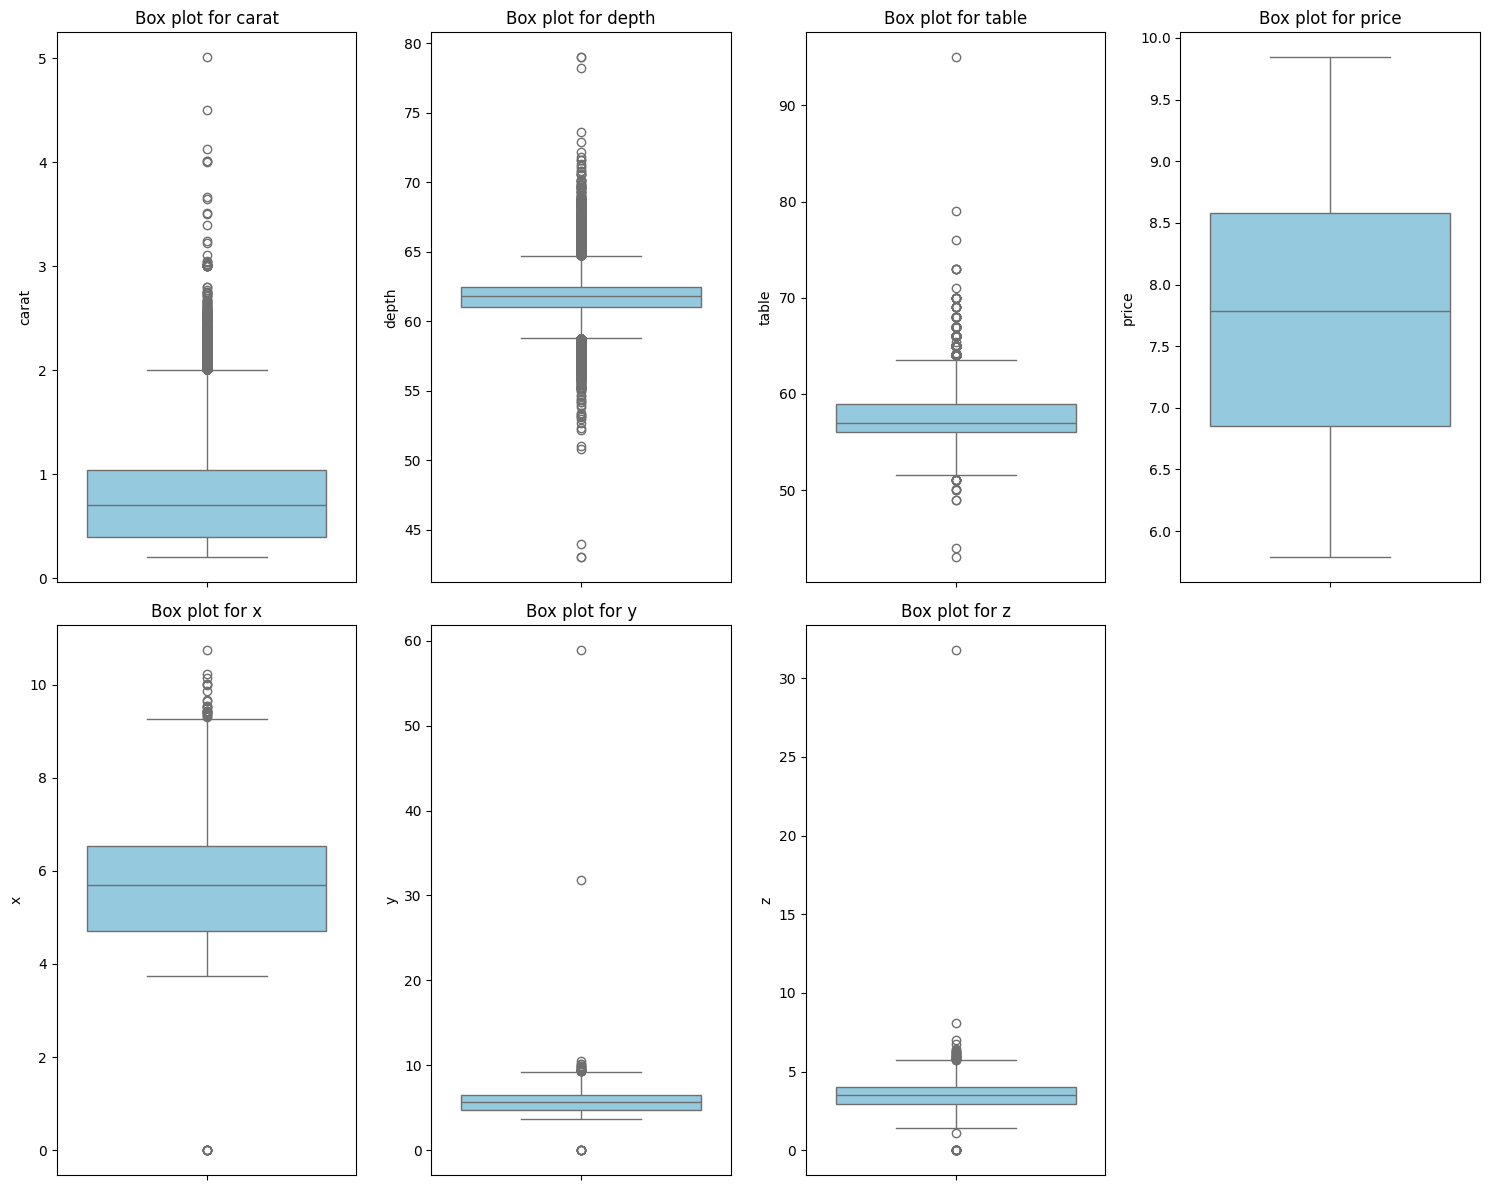

In [12]:
plot_boxplots(df)

$\text{Q1}$ = 25th percentile

$\text{Q3}$ = 75th percentile

$\text{IQR}$ = Interquartile (50% at the middle) $= \text{Q3} - \text{Q1}$

Lower bound $= \text{Q1} - 1.5 \times \text{IQR}$

Upper bound $= \text{Q3} + 1.5 \times \text{IQR}$

In [13]:
def remove_outliers_iqr(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove outliers from all numerical columns in the dataframe using the IQR method.

    Args:
        df: The input dataframe.

    Returns:
        DataFrame with outliers removed from all numerical columns.
    """
    numerical_columns = df.select_dtypes(include="number").columns
    for column in numerical_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df

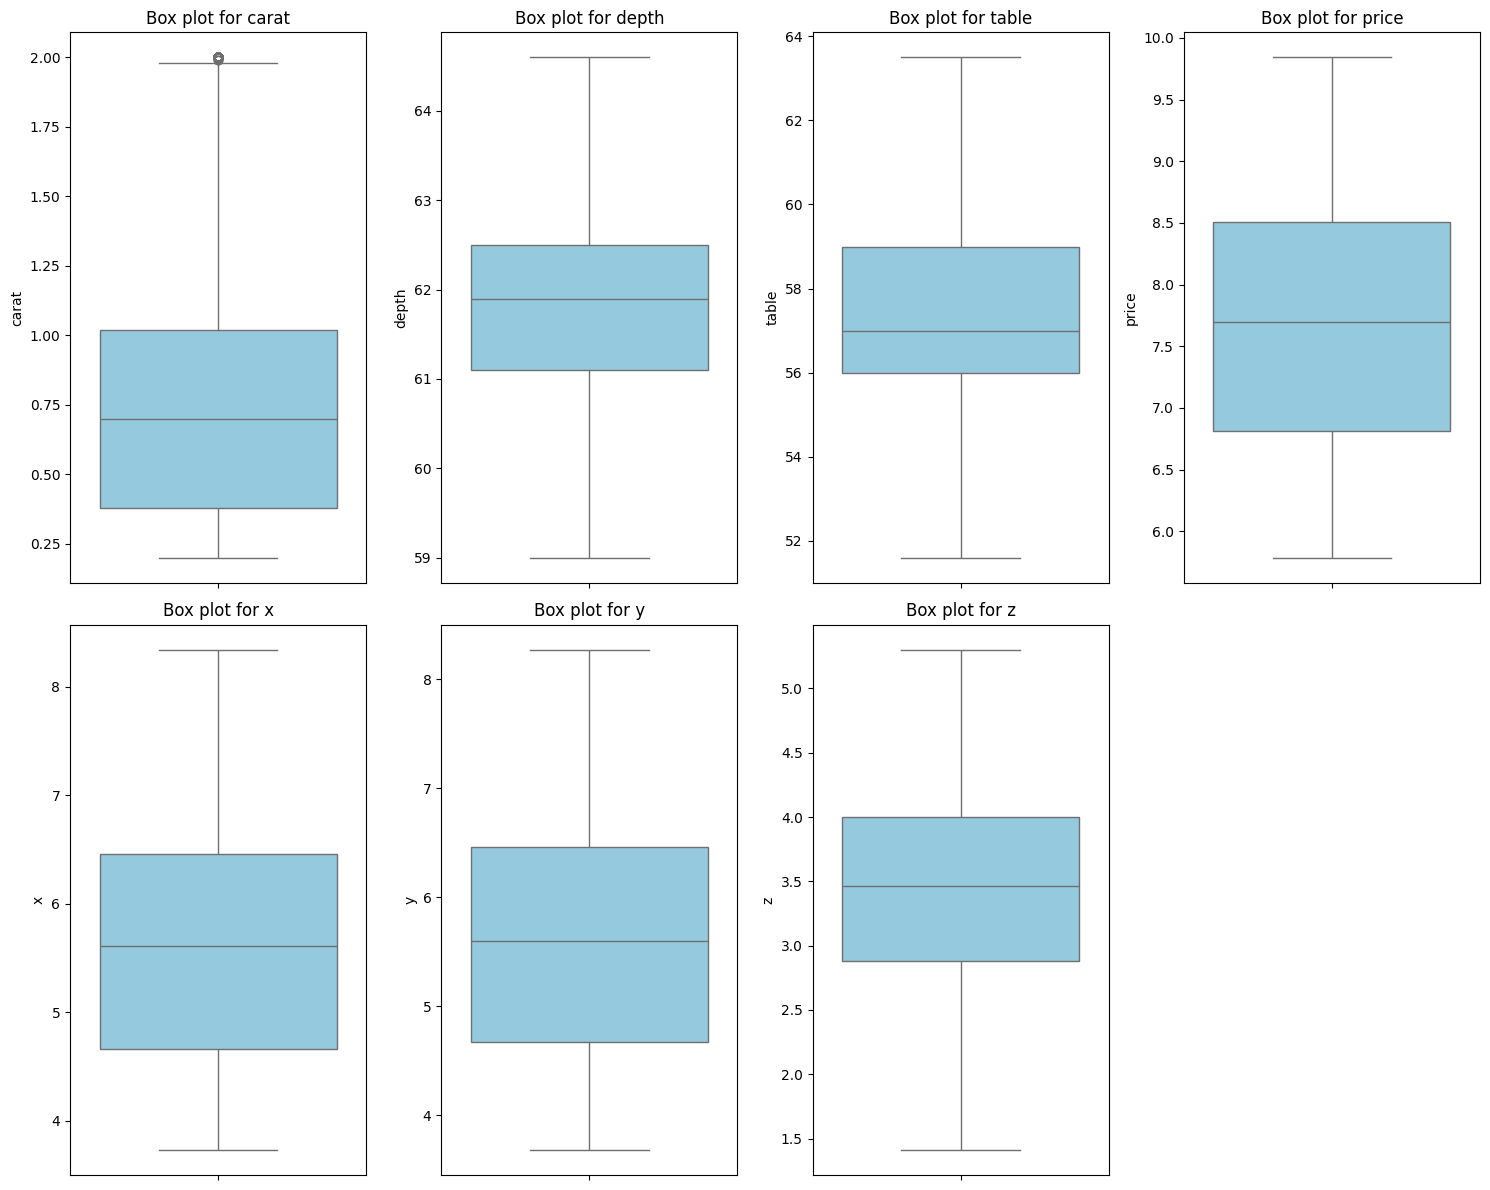

In [14]:
# Remove outliers
df = remove_outliers_iqr(df)
plot_boxplots(df)

### Handling Categorical Features
Encoding Categorical Features:
- **cut**: Ordinal encoding (Fair < Good < Very Good < Premium < Ideal).
- **color**: Ordinal encoding (J < I < H < G < F < E < D).
- **clarity**: Ordinal encoding (I1 < SI2 < SI1 < VS2 < VS1 < VVS2 < VVS1 < IF).

In [15]:
from sklearn.preprocessing import OrdinalEncoder


categories = [
    ["Fair", "Good", "Very Good", "Premium", "Ideal"],
    ["J", "I", "H", "G", "F", "E", "D"],
    ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"],
]

encoder = OrdinalEncoder(categories=categories)
df[["cut", "color", "clarity"]] = encoder.fit_transform(df[["cut", "color", "clarity"]])

### Standardisation
Some machine learning models, such as Linear Regression (especially with regularisation), K-Nearest Neighbours (KNN), and Support Vector Machines (SVM), are sensitive to the scale of input features because they compute distances or rely on dot products. Therefore, feature scaling is essential to ensure fair contribution of each feature and to avoid biased results.

Standardisation is generally preferred for most algorithms when features are normally distributed or when using regularised models. Normalisation would be useful if the data are not Gaussian or when we want all features strictly in the same range (e.g., for neural networks)

- Scale all numerical features (including boolean features).
- Always fit the scaler **only on training features** (X_train) and use it to transform test features (X_test).
- `.fit_transform(X_train)` and `.transform(X_test)`
- Do not scale the target variable unless there is a specific reason.
    - If the target variable needs to be scaled, invert the transformation before interpreting results.

This process will be included in Pipeline.

## 5. Predictive Modelling
For this regression tasks, the following six regressors will be compared and evaluted:
- Linear Regression
- Ridge Regression
- Lasso Regression
- K-Nearest Neighbours Regressor
- Random Forest Regressor
- XGBoost Regressor

In [16]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split

In [17]:
X, y = df.drop(columns=["price"]), df["price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Hyperparameter Tuning
Optimisation of hyperparameters is essential to obtain the best performance from Ridge Regression, Lasso Regression, KNN Regressor, XGBoost and Random Forest models. **Grid Search** or **Random Search** is typically used to find the best hyperparameters.

The scikit-learn library provides **GridSearchCV** and **RandomizedSearchCV** functions widely used for grid and random search with cross-validation.

Instead of manually repeating the hyperparameter tuning process for each model under evaluation, we can employ a `Pipeline` to automate the entire workflow. A pipeline establishes a structured sequence for data preprocessing, model building, and evaluation. This approach enables us to modularise the machine learning process, making it significantly more efficient and scalable.

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

alphas = [0.1, 1, 10, 100]

regressors = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(max_iter=10000),
    "KNN": KNeighborsRegressor(),
    "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0, n_jobs=-1),
}

param_grids = {
    "Linear Regression": {},
    "Ridge Regression": {"regressor__alpha": alphas},
    "Lasso Regression": {"regressor__alpha": alphas},
    "KNN": {
        "regressor__n_neighbors": [12, 16, 20, 24],
        "regressor__weights": ["uniform", "distance"],
        "regressor__metric": ["euclidean", "manhattan"],
    },
    "Random Forest": {
        "regressor__n_estimators": [100, 200],
        "regressor__max_depth": [None, 5, 8, 12],
        "regressor__max_features": ["sqrt", "log2"],
    },
    "XGBoost": {
        "regressor__n_estimators": [100, 200],
        "regressor__max_depth": [5, 8, 12],
        "regressor__learning_rate": [0.01, 0.1, 0.2],
    },
}

In [19]:
def find_best_estimators(
    regressors: Dict[str, Any],
    X_train: pd.DataFrame,
    y_train: pd.Series,
    n_splits: int = 5,
) -> Dict[str, Any]:
    """
    Perform hyperparameter tuning using GridSearchCV for multiple regressors.

    Args:
        regressors: A dictionary where keys are regressors names (str) and values are
            regressor instances (e.g., scikit-learn estimators).
        X_train: Training features.
        y_train: Training target labels.
        n_splits: Number of splits for StratifiedKFold cross-validation. Defaults to 5.

    Returns:
        A dictionary mapping regressor names to their best fitted pipeline (including preprocessing
        and the regressor with optimal hyperparameters).

    """
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    best_estimators = {}

    for name, regressor in regressors.items():
        print(f"\n===== {name} =====")
        pipeline = Pipeline([("scaler", StandardScaler()), ("regressor", regressor)])
        param_grid = param_grids[name]
        grid = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            scoring="neg_root_mean_squared_error",
            cv=cv,
            n_jobs=-1,
        )
        grid.fit(X_train, y_train)
        best_estimators[name] = grid.best_estimator_

        print(f"{name}:")
        print(f"  Best Params: {grid.best_params_}")
        print(f"  Best CV RMSE: {-grid.best_score_:.4f}\n")
    return best_estimators


In [20]:
best_estimators = find_best_estimators(regressors, X_train=X_train, y_train=y_train)


===== Linear Regression =====
Linear Regression:
  Best Params: {}
  Best CV RMSE: 0.1413


===== Ridge Regression =====
Ridge Regression:
  Best Params: {'regressor__alpha': 10}
  Best CV RMSE: 0.1413


===== Lasso Regression =====
Lasso Regression:
  Best Params: {'regressor__alpha': 0.1}
  Best CV RMSE: 0.2698


===== KNN =====
KNN:
  Best Params: {'regressor__metric': 'manhattan', 'regressor__n_neighbors': 16, 'regressor__weights': 'distance'}
  Best CV RMSE: 0.1162


===== Random Forest =====


/Users/tsu76i/Documents/Programming/Personal Projects/DS_Projects/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Random Forest:
  Best Params: {'regressor__max_depth': None, 'regressor__max_features': 'sqrt', 'regressor__n_estimators': 200}
  Best CV RMSE: 0.0895


===== XGBoost =====
XGBoost:
  Best Params: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 8, 'regressor__n_estimators': 200}
  Best CV RMSE: 0.0820



### Evaluation on Test Data
- The log transformation was maintained during training and tuning phases only.
- It must be reverted after prediction and before calculating final evaluation metrics.

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def evaluate_regressor(
    model: Dict[str, Any], X_test: pd.DataFrame, y_test: pd.Series
) -> Dict[str, Any]:
    """
    Evaluate a trained regression model on a test dataset using standard regression metrics.

    Args:
        model: The trained regression model supporting the .predict() method (e.g., scikit-learn estimator).
        X_test: Test feature data.
        y_test: True target values for the test data.

    Returns:
        A dictionary containing the following regression metrics:
            - 'MSE': Mean Squared Error.
            - 'RMSE': Root Mean Squared Error.
            - 'MAE': Mean Absolute Error.
            - 'R-Squared': Coefficient of determination.
    """
    y_pred = model.predict(X_test)
    y_pred, y_test = np.exp(y_pred), np.exp(y_test)  # Revert log transformation
    mse = round(mean_squared_error(y_test, y_pred), 4)
    rmse = round(np.sqrt(mse), 4)
    mae = round(mean_absolute_error(y_test, y_pred), 4)
    r2 = round(r2_score(y_test, y_pred), 4)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R-Squared": r2}

In [22]:
best_model_lr = best_estimators["Linear Regression"]
best_model_ridge = best_estimators["Ridge Regression"]
best_model_lasso = best_estimators["Lasso Regression"]
best_model_knn = best_estimators["KNN"]
best_model_rf = best_estimators["Random Forest"]
best_model_xgb = best_estimators["XGBoost"]

results_lr = evaluate_regressor(best_model_lr, X_test, y_test)
results_ridge = evaluate_regressor(best_model_ridge, X_test, y_test)
results_lasso = evaluate_regressor(best_model_lasso, X_test, y_test)
results_knn = evaluate_regressor(best_model_knn, X_test, y_test)
results_rf = evaluate_regressor(best_model_rf, X_test, y_test)
results_xgb = evaluate_regressor(best_model_xgb, X_test, y_test)


In [23]:
results_df = pd.DataFrame(
    [results_lr, results_ridge, results_lasso, results_knn, results_rf, results_xgb],
    index=[
        "Linear Regression",
        "Ridge Regression (L2)",
        "Lasso Regression (L1)",
        "KNN",
        "Random Forest",
        "XGBoost",
    ],
)
print(results_df)

                                MSE       RMSE       MAE  R-Squared
Linear Regression      5.006884e+05   707.5934  383.3906     0.9570
Ridge Regression (L2)  4.997706e+05   706.9446  382.4439     0.9570
Lasso Regression (L1)  1.892801e+06  1375.7910  730.9032     0.8373
KNN                    2.762453e+05   525.5904  275.2075     0.9763
Random Forest          1.941267e+05   440.5982  226.6436     0.9833
XGBoost                1.687387e+05   410.7782  210.4547     0.9855


## 6. Conclusion
A comprehensive evaluation of six regression models was conducted on the diamond price prediction task. All evaluation metrics were computed in the original price scale for interpretability.

- **XGBoost** achieved the best overall performance, with the lowest MSE ($168,738.7$), RMSE ($410.7782$) and MAE ($210.4547$), as well as the highest $R^2$ ($0.9855$). This demonstrates that XGBoost provides the most accurate and reliable predictions for diamond prices among all the models evaluated.

- **Random Forest** also performed exceptionally well, closely following XGBoost on all metrics, thus is a good alternative for this regression task.

- **KNN** outperformed all linear models, proving the strength of non-linear, instance-based learning for capturing complex patterns in the data.

- **Linear Regression** and **Ridge Regression** had nearly identical results, both with strong but slightly inferior predictive accuracy compared to tree-based and KNN models. It suggests that simple linear regressions are not fully capable of capturing the intricacies of diamond pricing.

- **Lasso Regression** underperformed relative to the other models, with substantially higher error metrics and a lower $R^2$. This implies underfitting caused by the L1 penalty.

## 7. References

1. Omondi, Evans (2023). *Assessing predictive performance of supervised machine learning algorithms for a diamond pricing model [Dataset]*. Dryad. <br>
https://doi.org/10.5061/dryad.wh70rxwrh

1. Shivam Agrawal. (2017). *Diamonds*.<br>
https://www.kaggle.com/datasets/shivam2503/diamonds

1. Xiao, Minxi. (2024). *Diamond Price Prediction Based on Regression Algorithms: Analyzing Key Factors and Model Performance*. Advances in Economics, Management and Political Sciences. 139. 196-205. 10.54254/2754-1169/2024.19476. <br>
https://www.researchgate.net/publication/387713186_Diamond_Price_Prediction_Based_on_Regression_Algorithms_Analyzing_Key_Factors_and_Model_Performance